In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
pd.options.display.max_columns = None

## Read Data (train set)

In [2]:
_, df = utils.load()

In [3]:
# drop columns which would give data leakage
cols_to_drop = [
    "Acquiror Closing Price 60 Days After Ann Date ($)",
    "Acquiror Closing Price 90 Days After Ann Date ($)",
    "Acquiror Closing Price 180 Days After Ann Date ($)",
    "Target Closing Price 60 Days After Ann Date ($)",
    "Target Closing Price 90 Days After Ann Date ($)",
    "Target Closing Price 180 Days After Ann Date ($)",
    "Value Based on Effective Date ($mil)",
    "Value Common at Eff. Date ($mil)",
    "Equity Value at Effective Date ($mil)"
]

df = df.drop(columns=cols_to_drop)

## Exploratory Data Analysis

#### <b> Analysis of time to deal withdrawal / completion </b>
- This gives us some intuition of when to close positions which have been open for a long time. 
- We observe that as more time elapses from the announcement day, the probability of merger success must be revised lower. This gives us the motivation for setting our cut-off date to close our position in the strategy, regardless of merger status.

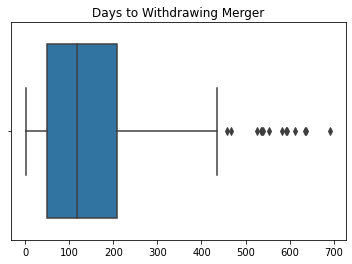

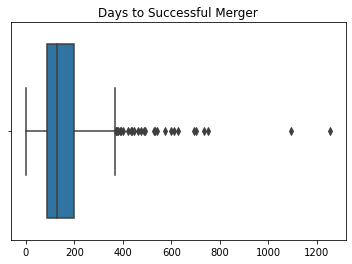

Median days to withdrawing merger: 117
For merger withdrawals, 180 days is at percentile: 0.71875
Median days to completing merger: 129
For merger success cases, 180 days is at percentile: 0.6969050160085379
75 percentile time taken for successful mergers: 199 days


In [4]:
failure_df = df[df["Success"]==0]
withdrawn_dates_df = failure_df[['Date Announced', 'Date Withdrawn']].dropna()
delta_withdrawal = withdrawn_dates_df["Date Withdrawn"] - withdrawn_dates_df["Date Announced"]
days_to_withdrawal = [delta.days for delta in delta_withdrawal]
plt.figure()
sns.boxplot(x=days_to_withdrawal).set(title='Days to Withdrawing Merger')

success_df = df[df["Success"]==1]
completed_dates_df = success_df[['Date Announced', 'Date Effective']].dropna()
delta_completion = completed_dates_df['Date Effective'] - completed_dates_df["Date Announced"]
days_to_completion = [delta.days for delta in delta_completion]
plt.figure()
sns.boxplot(x=days_to_completion).set(title='Days to Successful Merger')
plt.show()

print("Median days to withdrawing merger: " + str(round(np.median(days_to_withdrawal))))
print("For merger withdrawals, 180 days is at percentile: " + str((np.array(days_to_withdrawal) < 180).mean()))
print("Median days to completing merger: " + str(round(np.median(days_to_completion))))
print("For merger success cases, 180 days is at percentile: " + str((np.array(days_to_completion) < 180).mean()))
print(f"75 percentile time taken for successful mergers: {round(np.percentile(days_to_completion, 75))} days")

#### <b> Imbalanced Data </b>
- The data is positively skewed. This would affect our choice of loss function, e.g. using focal loss instead of binary cross entropy and our choice of metrics. 
- It would also affect our choice of performance metrics, for e.g. choosing AUC score from ROC curve. 
- We will also try to apply synthetic data creation methods, such as SMOTE, GAN or VAEs in the training step.

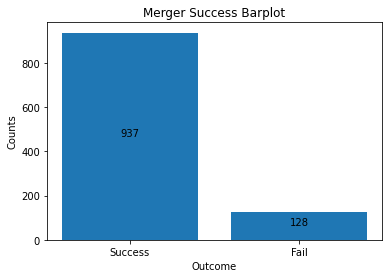

In [5]:
df_success_counts = df["Success"].value_counts().rename_axis('Outcome').reset_index(name='Counts')
df_success_counts["Outcome"] = df_success_counts["Outcome"].replace([1, 0], ["Success", "Fail"])

x, y = df_success_counts["Outcome"], df_success_counts["Counts"]
plt.bar(x, y)
utils.add_labels_inside_chart(x,y)
plt.xlabel("Outcome")
plt.ylabel("Counts")
plt.title("Merger Success Barplot")

plt.show()

#### <b> Time Factor </b>
- We perform a chi-squared test to determine if the month of annoucement has any bearing on merger outcome 

'Independent (fail to reject H0)'

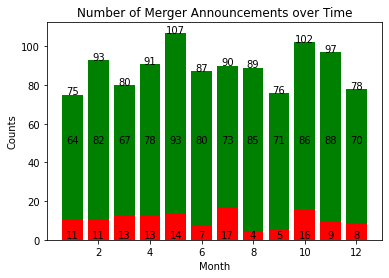

In [6]:
failure_by_month_df = df[df["Success"]==0]["Date Announced"].dt.month.value_counts().rename_axis('Month').reset_index(name='Counts').sort_values(by=["Month"])
success_by_month_df = df[df["Success"]==1]["Date Announced"].dt.month.value_counts().rename_axis('Month').reset_index(name='Counts').sort_values(by=["Month"])
df_month = df["Date Announced"].dt.month.value_counts().rename_axis('Month').reset_index(name='Counts').sort_values(by=["Month"])
x, y, y_fail, y_success = list(failure_by_month_df["Month"]),list(df_month["Counts"]), list(failure_by_month_df["Counts"]), list(success_by_month_df["Counts"])

fig, ax = plt.subplots()
plt.bar(x, y_fail, color='r')
plt.bar(x, y_success,  bottom=y_fail, color='g')

# label
for i in range(len(x)):
    plt.text(i+1, y[i], y[i], ha = 'center')
    plt.text(i+1, 1, y_fail[i], ha = 'center')
    plt.text(i+1, 50, y_success[i], ha = 'center')
    
plt.xlabel("Month")
plt.ylabel("Counts")
plt.title("Number of Merger Announcements over Time")

month_success_table = np.array([list(failure_by_month_df["Counts"]), list(success_by_month_df["Counts"])]).T
utils.chi_squared_test(month_success_table)

#### <b> Industry Factor </b>
- We compare the merger success rate for different industries (enforce minimum number of samples)
- We see that there is likely some useful signal here

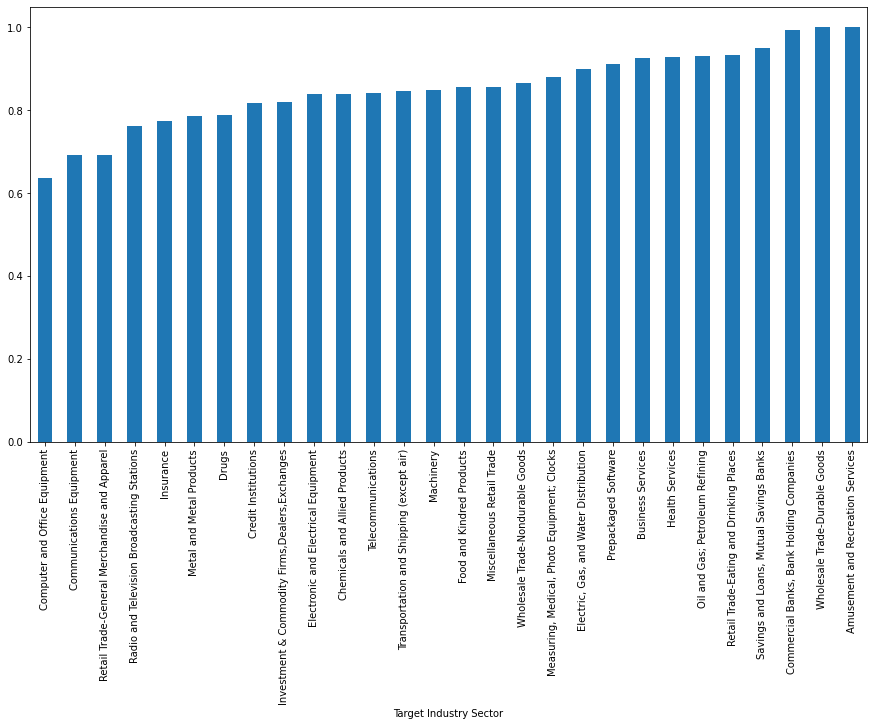

In [7]:
success_by_industry = pd.pivot_table(df, values="Success", index="Target Industry Sector", aggfunc={"Success": [np.sum, np.mean]})
industry_compare = pd.merge(success_by_industry, df.groupby("Target Industry Sector").size().rename("Sample Size"), how="left", on="Target Industry Sector")
industry_compare.columns = ["Mean Success", "Number of Success", "Sample Size"]
industry_compare["Number of Failures"] = industry_compare["Sample Size"] - industry_compare["Number of Success"]
industry_compare["Percentage Success"] = industry_compare["Number of Success"]/industry_compare["Sample Size"] 
industry_compare["Percentage Failure"] = industry_compare["Number of Failures"]/industry_compare["Sample Size"] 

industry_compare = industry_compare[industry_compare["Sample Size"] >= industry_compare["Sample Size"].median()] # keep industries with large enough samples
industry_compare["Percentage Success"].sort_values().plot(kind="bar", figsize=(15,8))
plt.show()

## Select columns

In [8]:
# set infs to nan
df = df.replace([np.inf, -np.inf], np.nan)

# drop columns with >50% missing data
percentage_missing_values = df.isnull().sum() / df.shape[0]
cols_to_drop = list(percentage_missing_values[percentage_missing_values.values > 0.5].index)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
non_numeric_cols = list(filter(lambda column: column not in df.select_dtypes(include=numerics).columns, df.columns)) 

In [9]:
cleaned_df = df.copy()
repeated_categorical_cols = ['Acquiror Name', 'Target Name'] # value can be captured with Acquiror/Target Primary Ticker Symbol
date_cols = ['Date Announced', 'Date Effective', 'Date Withdrawn'] # the dates of the previous mergers are not relevant to users predicting for future mergers
cols_to_drop = list(set(cols_to_drop + date_cols + repeated_categorical_cols))
cleaned_df = cleaned_df.drop(cols_to_drop, axis=1) # contains cols which require knowledge of merger result
cleaned_df.shape

(1065, 68)

# Feature Selection

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_regression, SelectPercentile
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

In [11]:
X = cleaned_df.drop("Success", axis=1)
y = cleaned_df["Success"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = list(X_train.select_dtypes(include=numerics).columns)
categorical_cols = list(filter(lambda column: column not in numeric_cols, X_train.columns))

numerical_X_train = X_train[numeric_cols]
categorical_X_train = X_train[categorical_cols]
processed_numerical_X_train = numerical_X_train.copy()
knn_imputer = KNNImputer(n_neighbors=2)  
processed_numerical_X_train[:] = knn_imputer.fit_transform(numerical_X_train)

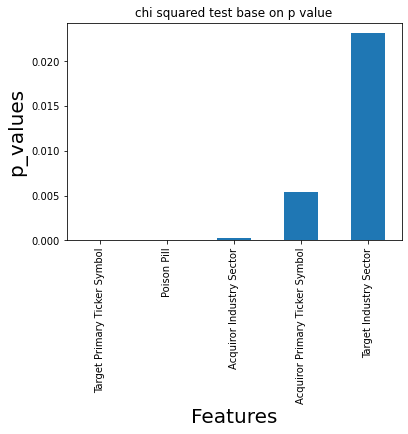

In [13]:
le = LabelEncoder()
processed_categorical_X = categorical_X_train.copy()
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
processed_categorical_X[:] = categorical_imputer.fit_transform(categorical_X_train)
for col in processed_categorical_X.columns:
    processed_categorical_X[col] = le.fit_transform(processed_categorical_X[col].astype(str))


f_score=chi2(processed_categorical_X,y_train)   #returns f score and p value
p_value=pd.Series(f_score[1],index=processed_categorical_X.columns)[:10]
p_value.sort_values(ascending=True,inplace=True)
p_value.plot(kind="bar")
plt.xlabel("Features",fontsize=20)
plt.ylabel("p_values",fontsize=20)
plt.title("chi squared test base on p value")
plt.show()

In [14]:
# generate dataset
org_cols = processed_numerical_X_train.columns
# define feature selection
fs = SelectKBest(score_func=f_classif, k='all')
# learn relationship from training data
fs.fit(processed_numerical_X_train, y_train)

col_and_score_list = []
for i in range(len(fs.scores_)):
  col_name = org_cols[i]
  score = fs.scores_[i]
  col_and_score_list.append((col_name, score))

sorted_col_and_score_list_f_classif = sorted(col_and_score_list, key=lambda tup: tup[1], reverse=True)
for tup in sorted_col_and_score_list_f_classif[:10]:
  print('%s: %f' % (tup[0], tup[1]))

Target Common Equity ($mil): 15.612536
Target Total Assets ($mil): 14.974372
Target Net Sales LTM ($mil): 13.879061
Target Net Assets ($mil): 12.517014
Pre-tax Income Last Twelve Months ($ Mil): 9.153975
Target Book Value/sh: 9.075548
Target EBITDA Five Year Growth Rate: 8.490649
Equity Value/ Net Sales: 8.450221
Ratio of Deal Value to Sales: 8.060368
Target Capital Expend.: 7.772778


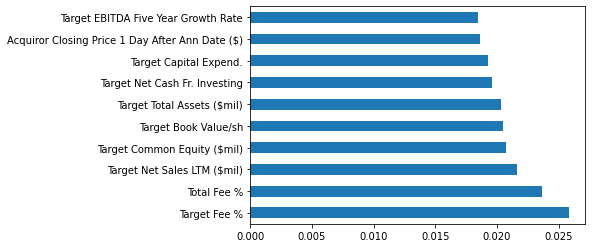

In [15]:
# Feature Selection By Feature Importance
model = ExtraTreesClassifier()
model.fit(processed_numerical_X_train,y_train)
feature_importances = pd.Series(model.feature_importances_, index=processed_numerical_X_train.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

['Premium 1 week prior to announce- ment date',
 'Ratio of Deal Value to EBIT',
 'Ratio of Deal Value to EBITDA',
 'Ratio of Deal Value to Net Income',
 'Ratio of Enterprise Value to EBITDA',
 'Ratio of Equity Value at Announcement to EBITDA',
 'Target Net Assets Five Year Growth Rate',
 'Total Fee %',
 'Target Fee %',
 'Target Total Lia. 5-Year Growth Rate (%)',
 'EBIT / Return on Assets',
 'Enterprise Value / Net Assets',
 'Enterprise Value / Tangible Book Value',
 'Target Net Sales LTM ($mil)',
 'EBIT Last Twelve Months ($ Mil)',
 'Pre-tax Income Last Twelve Months ($ Mil)',
 'Target EBITDA LTM ($mil)',
 'Target Cash & Mktbl',
 'Target Net Cash fr. Financing']

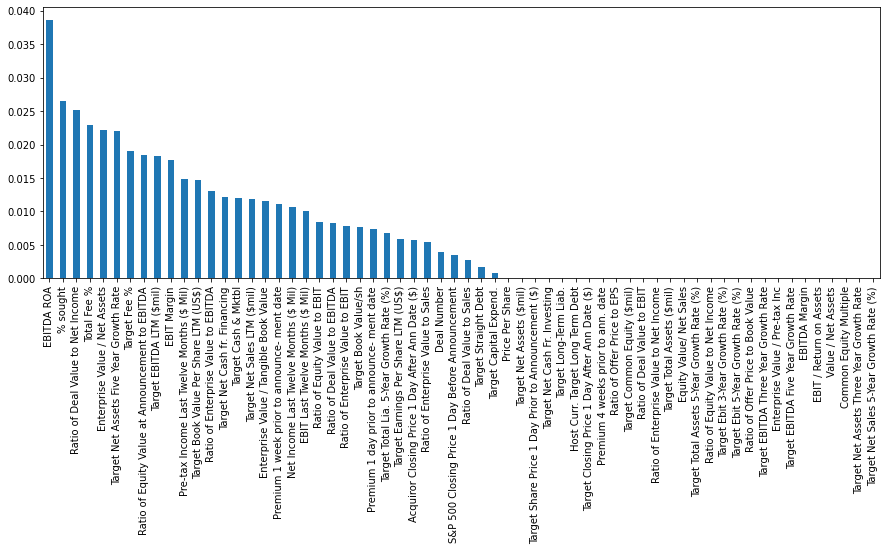

In [21]:
# Feature Selection by Mutual Information
mutual_info = mutual_info_regression(processed_numerical_X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = processed_numerical_X_train.columns
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

selected_top_columns = SelectPercentile(mutual_info_regression, percentile=30)
selected_top_columns.fit(processed_numerical_X_train, y_train)
selected_top_columns.get_support()
cols_with_most_information = list(processed_numerical_X_train.columns[selected_top_columns.get_support()])
cols_with_most_information

In [17]:
print("Features Selected:")
cols_with_most_information

Features Selected:


['Premium 1 week prior to announce- ment date',
 'Ratio of Deal Value to EBIT',
 'Ratio of Deal Value to Net Income',
 'Ratio of Enterprise Value to EBITDA',
 'Ratio of Equity Value to EBIT',
 'Ratio of Equity Value at Announcement to EBITDA',
 'EBIT Margin',
 'Target Net Assets Five Year Growth Rate',
 'Target Fee %',
 'Value / Net Assets',
 'EBIT / Return on Assets',
 'Enterprise Value / Net Assets',
 'Enterprise Value / Tangible Book Value',
 'Target Net Sales LTM ($mil)',
 'EBIT Last Twelve Months ($ Mil)',
 'Target EBITDA LTM ($mil)',
 'Target Cash & Mktbl',
 'Target Net Cash fr. Financing',
 'Target Straight Debt']

In [25]:
df.groupby("Success")["Ratio of Deal Value to Net Income"].mean()

Success
0     73.459817
1    127.294533
Name: Ratio of Deal Value to Net Income, dtype: float64